# Data exploration
Currently based on the entries from dbCAN-PUL

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# TO GET ETE4 TO WORK: python -c "from ete4 import NCBITaxa; NCBITaxa().update_taxonomy_database()"
from ete4 import NCBITaxa
ncbi = NCBITaxa()

In [ ]:
metadata = pd.read_excel("../DBCAN-PUL/dbCAN-PUL_Feb-2025.xlsx")
metadata.drop(columns=["PMID", "genomic_accession_number", "gene_locus_tags_or_modular", "old_other_gene_locus_tags_or_modules", "cazy_diamond_eval", "dbcan_hmmer_eval", "hotpep_hits", "tp_eval"], inplace=True)
metadata.head()

,ID,verification_final,nucleotide_position_range,substrate_final,organism_name,ncbi_species_tax_id,degradation_biosynthesis,num_cgcs,cazymes_predicted_dbCAN2,num_cazymes,num_genes,cazymes_predicted_dbcan
0,PUL0001,"RNA-Seq,substrate binding assay,enzyme activit...",156723-175880,beta-mannan,Roseburia intestinalis,166486,degradation,1,yes,9,15,"CE17|CBM35inCE17,CE2,GH1,GH113,GH130_1,GH130_2..."
1,PUL0002,"enzyme activity assay,Northern Blot",10377-12234,beta-glucan,Bacillus subtilis,1423,degradation,0,yes,1,2,GH16_21
2,PUL0003,RT-PCR,1942714-1945654,xylan,Bacillus subtilis,1423,degradation,0,yes,2,2,"GH30_8,GH43_16|CBM6"
3,PUL0004,"enzyme activity assay,substrate binding assay",1-3311,beta-glucan,uncultured bacterium,77133,degradation,1,yes,1,2,GH1
4,PUL0005,"enzyme activity assay,crystallization",1844298-1849726,beta-glucan,Listeria innocua,1642,degradation,0,yes,2,2,"GH3,GH94"


In [93]:
def get_length(pos_range):
    if ',' in pos_range:
        pos_range = pos_range.split(',')[0]
    pos_range = pos_range.split('-')
    length = np.abs(float(pos_range[1]) - float(pos_range[0]))
    return length

def get_phylum(id):
    lineage = ncbi.get_lineage(id)
    ranks = ncbi.get_rank(lineage)
    names = ncbi.get_taxid_translator(lineage)

    for tid in lineage:
        if ranks.get(tid) in ("phylum", "clade"):
            return names.get(tid)
    return "Unknown"

metadata["PUL_length"] = metadata["nucleotide_position_range"].apply(get_length)
metadata['phylum'] = metadata["ncbi_species_tax_id"].apply(get_phylum)
metadata["proportion_cazymes"] = metadata["num_cazymes"].divide(metadata["num_genes"])

metadata.head()

,ID,verification_final,nucleotide_position_range,substrate_final,organism_name,ncbi_species_tax_id,degradation_biosynthesis,num_cgcs,cazymes_predicted_dbCAN2,num_cazymes,num_genes,cazymes_predicted_dbcan,PUL_length,phylum,proportion_cazymes
0,PUL0001,"RNA-Seq,substrate binding assay,enzyme activit...",156723-175880,beta-mannan,Roseburia intestinalis,166486,degradation,1,yes,9,15,"CE17|CBM35inCE17,CE2,GH1,GH113,GH130_1,GH130_2...",19157.0,Bacillota,0.6
1,PUL0002,"enzyme activity assay,Northern Blot",10377-12234,beta-glucan,Bacillus subtilis,1423,degradation,0,yes,1,2,GH16_21,1857.0,Bacillota,0.5
2,PUL0003,RT-PCR,1942714-1945654,xylan,Bacillus subtilis,1423,degradation,0,yes,2,2,"GH30_8,GH43_16|CBM6",2940.0,Bacillota,1.0
3,PUL0004,"enzyme activity assay,substrate binding assay",1-3311,beta-glucan,uncultured bacterium,77133,degradation,1,yes,1,2,GH1,3310.0,Unknown,0.5
4,PUL0005,"enzyme activity assay,crystallization",1844298-1849726,beta-glucan,Listeria innocua,1642,degradation,0,yes,2,2,"GH3,GH94",5428.0,Bacillota,1.0


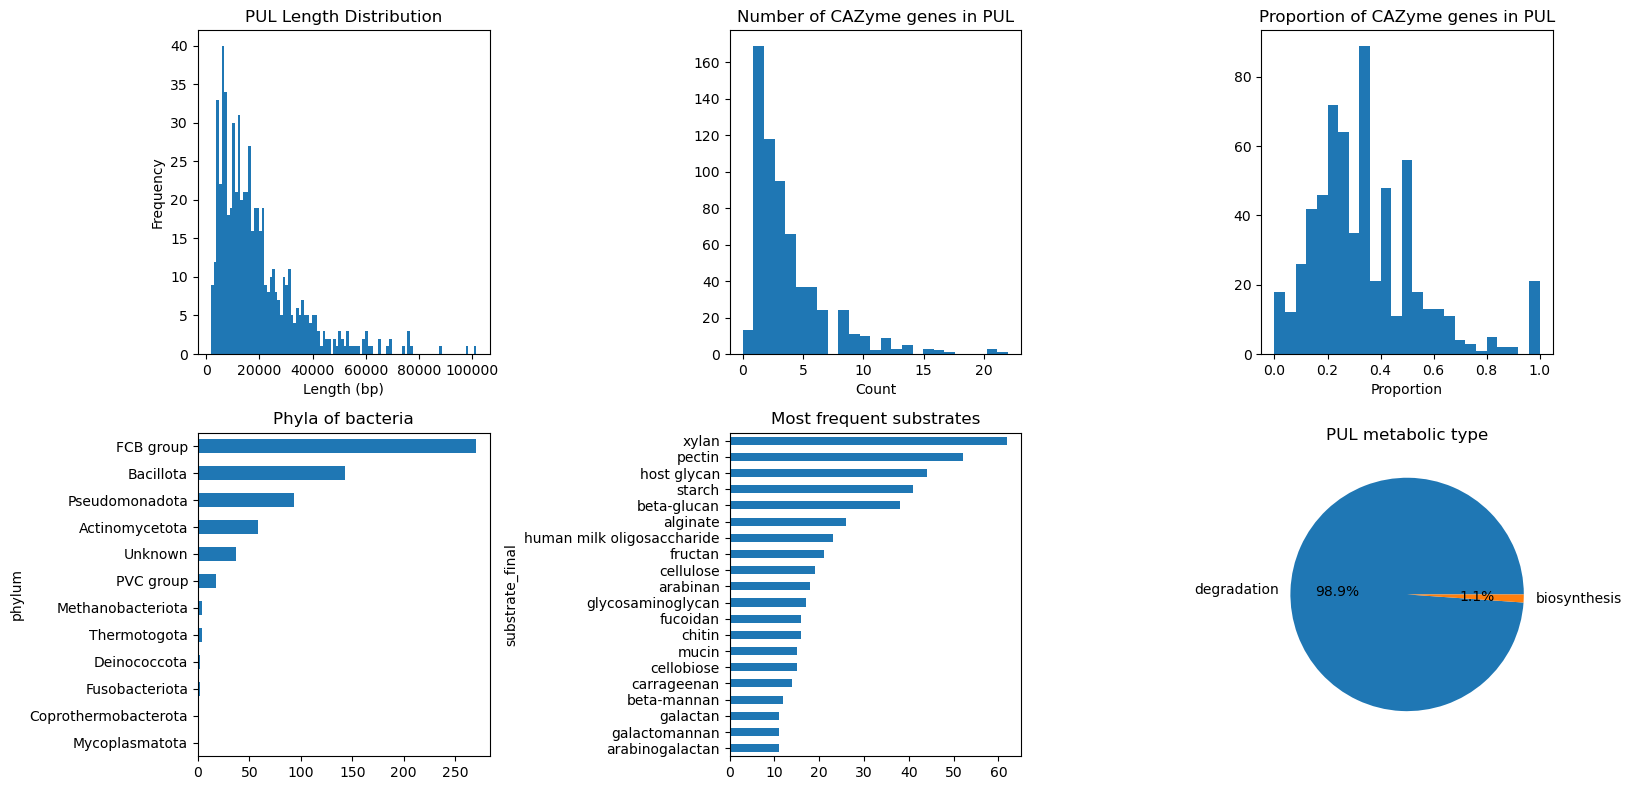

In [94]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

# plot PUL length distribution
length_plot = metadata["PUL_length"].plot.hist(title="PUL Length Distribution", bins=100, xlabel="Length (bp)", ax=axes[0])

# plot count of CAZymes in PUL
metadata['num_cazymes'].plot.hist(bins=25, ax=axes[1], title="Number of CAZyme genes in PUL", ylabel="", xlabel="Count")

# plot proportion of cazymes in PUL
metadata['proportion_cazymes'].plot.hist(bins=25, ax=axes[2], title="Proportion of CAZyme genes in PUL", ylabel="", xlabel="Proportion")

# plot taxonomic info
metadata['phylum'].apply(lambda s: s.strip()).value_counts().sort_values().plot.barh(ax=axes[3], title="Phyla of bacteria")

# plot substrate distribution
substrate_plot = metadata["substrate_final"].value_counts()[:20].sort_values().plot.barh(title="Most frequent substrates", ax=axes[4])

# plot type of PUL
metadata['degradation_biosynthesis'].apply(lambda s: s.strip()).value_counts().plot.pie(ax=axes[5], title="PUL metabolic type", autopct="%1.1f%%")

axes[5].set_aspect("equal")

plt.tight_layout()